# Reconocedor de señales de límite de velocidad

A continuación, se desarrollará una red neuronal que permita el reconocimiento de las distintas señales de límite de velocidad. Para ello se utilizará un dataset obtenido de https://www.kaggle.com/flo2607/traffic-signs-classification.

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')
!rm -rf ./dataset/
!unzip /content/dataset.zip -d /content/dataset/

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/dataset/train/70km/4_7158_1577671996.115584.jpg  
  inflating: /content/dataset/train/70km/4_7159_1577671996.1165924.jpg  
  inflating: /content/dataset/train/70km/4_7160_1577671996.1175785.jpg  
  inflating: /content/dataset/train/70km/4_7161_1577671996.1185765.jpg  
  inflating: /content/dataset/train/70km/4_7162_1577671996.120569.jpg  
  inflating: /content/dataset/train/70km/4_7163_1577671996.1215684.jpg  
  inflating: /content/dataset/train/70km/4_7164_1577671996.1225753.jpg  
  inflating: /content/dataset/train/70km/4_7165_1577671996.1235626.jpg  
  inflating: /content/dataset/train/70km/4_7166_1577671996.1245596.jpg  
  inflating: /content/dataset/train/70km/4_7167_1577671996.126553.jpg  
  inflating: /content/dataset/train/70km/4_7168_1577671996.1285474.jpg  
  inflating: /content/dataset/train/70km/4_7169_1577671996.129547.jpg  
  inflating: /content/dataset/train/70km/4_7170_1577671996.1305437.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


La imagenes usadas serán como la siguiente:

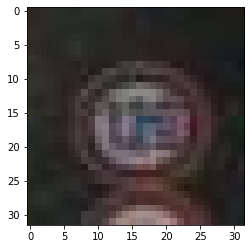

In [9]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open("/content/dataset/train/120km/00000_00009.jpg", 'r')
imshow(np.asarray(pil_im))

Leemos el dataset con las 7 distintas clases.

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from time import time

# DATA SOURCE

batch_size = 7
train_data_dir = "/content/dataset/train"
validation_data_dir = "/content/dataset/validation"
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (32, 32),
    batch_size = batch_size,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(32, 32),
    batch_size=5,
    class_mode='categorical'
)

Found 22802 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


## Modelo 1

Este primer modelo es el proporcionado en los apuntes de la asignatura, pero le cambiamos la forma de entrada, el número de salidas y la función de optimización para adaptarlo a nuestro dataset.

In [ ]:
from keras.models import Sequential
from keras.optimizers import Adadelta
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
import keras

# MODEL --------------------------------------------------

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=["accuracy"])

KeyboardInterrupt: ignored

El número de épocas que usaremos en este primer modelo será de 10.

In [ ]:
epochs = 50

hist = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
)

Epoch 1/50
100/100 [==============================] - 17s 23ms/step - loss: 1.9500 - accuracy: 0.1379 - val_loss: 1.8876 - val_accuracy: 0.2143
Epoch 2/50
100/100 [==============================] - 2s 18ms/step - loss: 1.8497 - accuracy: 0.2197 - val_loss: 1.9829 - val_accuracy: 0.2143
Epoch 3/50
100/100 [==============================] - 2s 18ms/step - loss: 1.7433 - accuracy: 0.2999 - val_loss: 1.9318 - val_accuracy: 0.2286
Epoch 4/50
100/100 [==============================] - 2s 19ms/step - loss: 1.7184 - accuracy: 0.3330 - val_loss: 2.0146 - val_accuracy: 0.2000
Epoch 5/50
100/100 [==============================] - 2s 18ms/step - loss: 1.6802 - accuracy: 0.3165 - val_loss: 1.8532 - val_accuracy: 0.3143
Epoch 6/50
100/100 [==============================] - 2s 18ms/step - loss: 1.6449 - accuracy: 0.3533 - val_loss: 1.7289 - val_accuracy: 0.2857
Epoch 7/50
100/100 [==============================] - 2s 18ms/step - loss: 1.6087 - accuracy: 0.3596 - val_loss: 1.7391 - val_accuracy: 0.342

La precisión media obtenida para este modelo es:

In [ ]:
print("Media:", np.mean(hist.history['accuracy']) * 100)

Media: 71.02571401000023


## Modelo 2

Para este modelo, hemos realizado las siguientes modificaciones en comparación con el anterior:
- Primeramente, hemos cambiado la función de activación de la última capa oculta de la relu a sigmoide.
- Además, hemos bajado la frecuencia de Dropout de un 0.25 a un 0.15 en su primera aparición y de 0.5 a 0.25 en su última aparición para así intentar que se entrenen más las neuronas, aunque esto puede aumentar el overfitting. 

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))

model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=["accuracy"])

In [ ]:
epochs = 50

hist = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
)

Epoch 1/50
100/100 [==============================] - 3s 22ms/step - loss: 1.9944 - accuracy: 0.1694 - val_loss: 1.9021 - val_accuracy: 0.2286
Epoch 2/50
100/100 [==============================] - 2s 19ms/step - loss: 1.8507 - accuracy: 0.2476 - val_loss: 1.8285 - val_accuracy: 0.3000
Epoch 3/50
100/100 [==============================] - 2s 19ms/step - loss: 1.7353 - accuracy: 0.3121 - val_loss: 1.9144 - val_accuracy: 0.3286
Epoch 4/50
100/100 [==============================] - 2s 18ms/step - loss: 1.6685 - accuracy: 0.3411 - val_loss: 1.8053 - val_accuracy: 0.4000
Epoch 5/50
100/100 [==============================] - 2s 18ms/step - loss: 1.6864 - accuracy: 0.3663 - val_loss: 1.7337 - val_accuracy: 0.3571
Epoch 6/50
100/100 [==============================] - 2s 18ms/step - loss: 1.5076 - accuracy: 0.4479 - val_loss: 1.7173 - val_accuracy: 0.3571
Epoch 7/50
100/100 [==============================] - 2s 19ms/step - loss: 1.4807 - accuracy: 0.4414 - val_loss: 1.5468 - val_accuracy: 0.3857

La precisión media para este modelo es:

In [ ]:
print("Media:", np.mean(hist.history['accuracy']) * 100)

Media: 78.78571420907974


###Modelo 2b

Para este modelo, vamos a realizar unos cambios en el apartado de la reescala de imágenes, subiendo el tamaño de las imágenes para ver si obtenemos mejores resultados.

In [ ]:
# DATA SOURCE

batch_size = 7
train_data_dir = "/content/dataset/train_reduced"
validation_data_dir = "/content/dataset/validation"
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (64, 64),
    batch_size = batch_size,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Found 700 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))

model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=["accuracy"])

In [ ]:
epochs = 50

hist = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
)

Epoch 1/50
100/100 [==============================] - 8s 67ms/step - loss: 2.0399 - accuracy: 0.1529 - val_loss: 1.8523 - val_accuracy: 0.2429
Epoch 2/50
100/100 [==============================] - 6s 63ms/step - loss: 1.7686 - accuracy: 0.3015 - val_loss: 1.8686 - val_accuracy: 0.2714
Epoch 3/50
100/100 [==============================] - 6s 63ms/step - loss: 1.6922 - accuracy: 0.3460 - val_loss: 1.9079 - val_accuracy: 0.2714
Epoch 4/50
100/100 [==============================] - 6s 64ms/step - loss: 1.5884 - accuracy: 0.3719 - val_loss: 1.6845 - val_accuracy: 0.3571
Epoch 5/50
100/100 [==============================] - 6s 64ms/step - loss: 1.3678 - accuracy: 0.4726 - val_loss: 1.3141 - val_accuracy: 0.4857
Epoch 6/50
100/100 [==============================] - 6s 65ms/step - loss: 1.1050 - accuracy: 0.6448 - val_loss: 1.0355 - val_accuracy: 0.6286
Epoch 7/50
100/100 [==============================] - 6s 65ms/step - loss: 0.8888 - accuracy: 0.7064 - val_loss: 0.8039 - val_accuracy: 0.7143

La media de precisión para este caso sería de:

In [ ]:
print("Media:", np.mean(hist.history['accuracy']) * 100)

Media: 85.97714278101921


##Modelo 3

Para este modelo cambiamos el kernel_size a 5,5 para intentar detectar un área mayor donde se encuentre el límite de velocidad. De resto nos encontramos con el modelo 2.


In [ ]:
# DATA SOURCE

batch_size = 7
train_data_dir = "/content/dataset/train_reduced"
validation_data_dir = "/content/dataset/validation"
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (32, 32),
    batch_size = batch_size,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

Found 700 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))

model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=["accuracy"])

In [ ]:
epochs = 50

hist = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
)

Epoch 1/50
100/100 [==============================] - 3s 22ms/step - loss: 1.9966 - accuracy: 0.1657 - val_loss: 1.8586 - val_accuracy: 0.3286
Epoch 2/50
100/100 [==============================] - 2s 18ms/step - loss: 1.8336 - accuracy: 0.2508 - val_loss: 1.9724 - val_accuracy: 0.2143
Epoch 3/50
100/100 [==============================] - 2s 18ms/step - loss: 1.7628 - accuracy: 0.2977 - val_loss: 1.8345 - val_accuracy: 0.3000
Epoch 4/50
100/100 [==============================] - 2s 18ms/step - loss: 1.6886 - accuracy: 0.3350 - val_loss: 1.9681 - val_accuracy: 0.2857
Epoch 5/50
100/100 [==============================] - 2s 18ms/step - loss: 1.6648 - accuracy: 0.3391 - val_loss: 1.7351 - val_accuracy: 0.3714
Epoch 6/50
100/100 [==============================] - 2s 19ms/step - loss: 1.4951 - accuracy: 0.4453 - val_loss: 1.7530 - val_accuracy: 0.3429
Epoch 7/50
100/100 [==============================] - 2s 18ms/step - loss: 1.3390 - accuracy: 0.4811 - val_loss: 1.3334 - val_accuracy: 0.5714

La media es igual a:

In [ ]:
print("Media:", np.mean(hist.history['accuracy']) * 100)

Media: 79.77714297175407


##Modelo 4

En este caso, usaremos el tamaño de imagen 32x32 pero se cambiará el batch_size de 7 a 20 para que así poder explorar más imágenes por entrenamiento, de resto, usaremos el esquema del modelo 2.

In [ ]:
batch_size = 20
train_data_dir = "/content/dataset/train_reduced"
validation_data_dir = "/content/dataset/validation"
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (32, 32),
    batch_size = batch_size,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(32, 32),
    batch_size=5,
    class_mode='categorical'
)

Found 700 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=["accuracy"])

In [ ]:
epochs = 50

hist = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
)

Epoch 1/50
35/35 [==============================] - 3s 52ms/step - loss: 1.9239 - accuracy: 0.1790 - val_loss: 1.8988 - val_accuracy: 0.2000
Epoch 2/50
35/35 [==============================] - 1s 41ms/step - loss: 1.8759 - accuracy: 0.2197 - val_loss: 1.8547 - val_accuracy: 0.2143
Epoch 3/50
35/35 [==============================] - 1s 41ms/step - loss: 1.7808 - accuracy: 0.2910 - val_loss: 1.8841 - val_accuracy: 0.2429
Epoch 4/50
35/35 [==============================] - 1s 41ms/step - loss: 1.7120 - accuracy: 0.3361 - val_loss: 2.0038 - val_accuracy: 0.1857
Epoch 5/50
35/35 [==============================] - 1s 41ms/step - loss: 1.6861 - accuracy: 0.3339 - val_loss: 1.8125 - val_accuracy: 0.3000
Epoch 6/50
35/35 [==============================] - 2s 47ms/step - loss: 1.6294 - accuracy: 0.3436 - val_loss: 1.8632 - val_accuracy: 0.3000
Epoch 7/50
35/35 [==============================] - 1s 41ms/step - loss: 1.6049 - accuracy: 0.3956 - val_loss: 1.8836 - val_accuracy: 0.3143
Epoch 8/50
35

Para este último modelo, la media sería igual a:

In [ ]:
print("Media:", np.mean(hist.history['accuracy']) * 100)

Media: 66.1742856502533


##Modelo final

El modelo que usaremos como final será el 2B pues es el que nos ha proporcionado una mayor precisión y un mejor rendimiento pero cambiando el batch_size en el generador para la validación a 7 y también le decimos que no mezcle los datos con la opción shuffle = False.

In [ ]:
batch_size = 7
train_data_dir = "/content/dataset/train_reduced"
validation_data_dir = "/content/dataset/validation"
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (64, 64),
    batch_size = batch_size,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(64, 64),
    shuffle=False,
    batch_size=7,
    class_mode='categorical'
)

Found 700 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))

model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=["accuracy"])

Entrenamos este modelo de nuevo, pero ahora realizamos 150 épocas en vez de 50 para poder tener un resultado más preciso.

In [ ]:
epochs = 150

hist = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
)

Epoch 1/150
100/100 [==============================] - 8s 68ms/step - loss: 2.1328 - accuracy: 0.1824 - val_loss: 2.0719 - val_accuracy: 0.2000
Epoch 2/150
100/100 [==============================] - 6s 63ms/step - loss: 1.7922 - accuracy: 0.2761 - val_loss: 1.8541 - val_accuracy: 0.3143
Epoch 3/150
100/100 [==============================] - 6s 64ms/step - loss: 1.6927 - accuracy: 0.3393 - val_loss: 1.6560 - val_accuracy: 0.4286
Epoch 4/150
100/100 [==============================] - 6s 64ms/step - loss: 1.5130 - accuracy: 0.4293 - val_loss: 1.4245 - val_accuracy: 0.4571
Epoch 5/150
100/100 [==============================] - 6s 64ms/step - loss: 1.3188 - accuracy: 0.4589 - val_loss: 1.4262 - val_accuracy: 0.4429
Epoch 6/150
100/100 [==============================] - 6s 64ms/step - loss: 1.1238 - accuracy: 0.5838 - val_loss: 0.9602 - val_accuracy: 0.5857
Epoch 7/150
100/100 [==============================] - 6s 65ms/step - loss: 0.9603 - accuracy: 0.6507 - val_loss: 0.7887 - val_accuracy:

Este sería el gráfico que muestra los rendimientos a lo largo del entrenamiento:

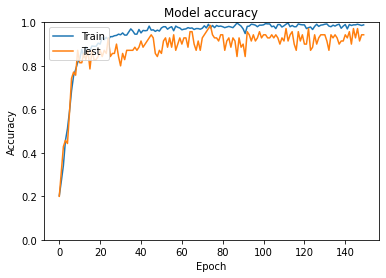

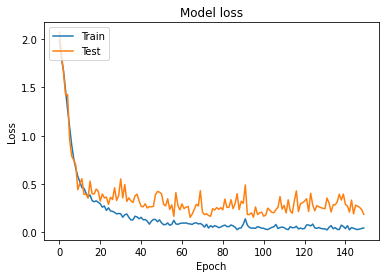

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##Resultados

###Matriz de confusión

Si ejecutamos el modelo obtenemos este resultado

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict_generator(validation_generator, 70 // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Matriz de confusión')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Resultados')
target_names = ['30km', '50km', '60km', '70km', '80km', '100km', '120km']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Matriz de confusión
[[ 9  0  0  0  0  0  1]
 [ 0  9  0  0  0  1  0]
 [ 0  0 10  0  0  0  0]
 [ 0  0  0 10  0  0  0]
 [ 0  0  0  0 10  0  0]
 [ 0  0  1  0  0  9  0]
 [ 0  1  0  0  0  0  9]]
Resultados
              precision    recall  f1-score   support

        30km       1.00      0.90      0.95        10
        50km       0.90      0.90      0.90        10
        60km       0.91      1.00      0.95        10
        70km       1.00      1.00      1.00        10
        80km       1.00      1.00      1.00        10
       100km       0.90      0.90      0.90        10
       120km       0.90      0.90      0.90        10

    accuracy                           0.94        70
   macro avg       0.94      0.94      0.94        70
weighted avg       0.94      0.94      0.94        70



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


A continuación, adjuntamos una tabla con los cambios realizados y sus resultados promediados en las 10 épocas de entrenamiento de cada modelo.

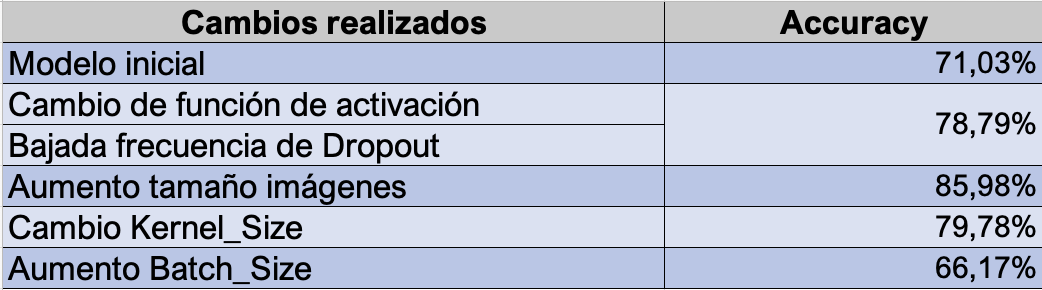